In [336]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
import keras
from keras.layers import Dense ,Dropout,LSTM, Input,concatenate
from keras.layers import Dense, LSTM
#from keras.layers.merge import concatenate
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error ,mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings

In [289]:
warnings.filterwarnings('ignore')

In [290]:
df = pd.read_excel("UoW_load.xlsx")
df = df.iloc[:,3:]
df_ = df.copy()
df.head()

,Dates,09:00,10:00,11:00
0,2018-01-01,89.4,90.6,88.6
1,2018-01-02,108.2,104.6,106.0
2,2018-01-03,110.0,111.6,114.8
3,2018-01-04,106.4,104.4,109.0
4,2018-01-05,97.8,100.4,102.4


In [291]:
df.shape

(500, 4)

In [292]:
df.isnull().sum()

Dates     0
09:00     0
10:00     0
11:00     0
dtype: int64

In [27]:
target_name = list(df.columns)[3]

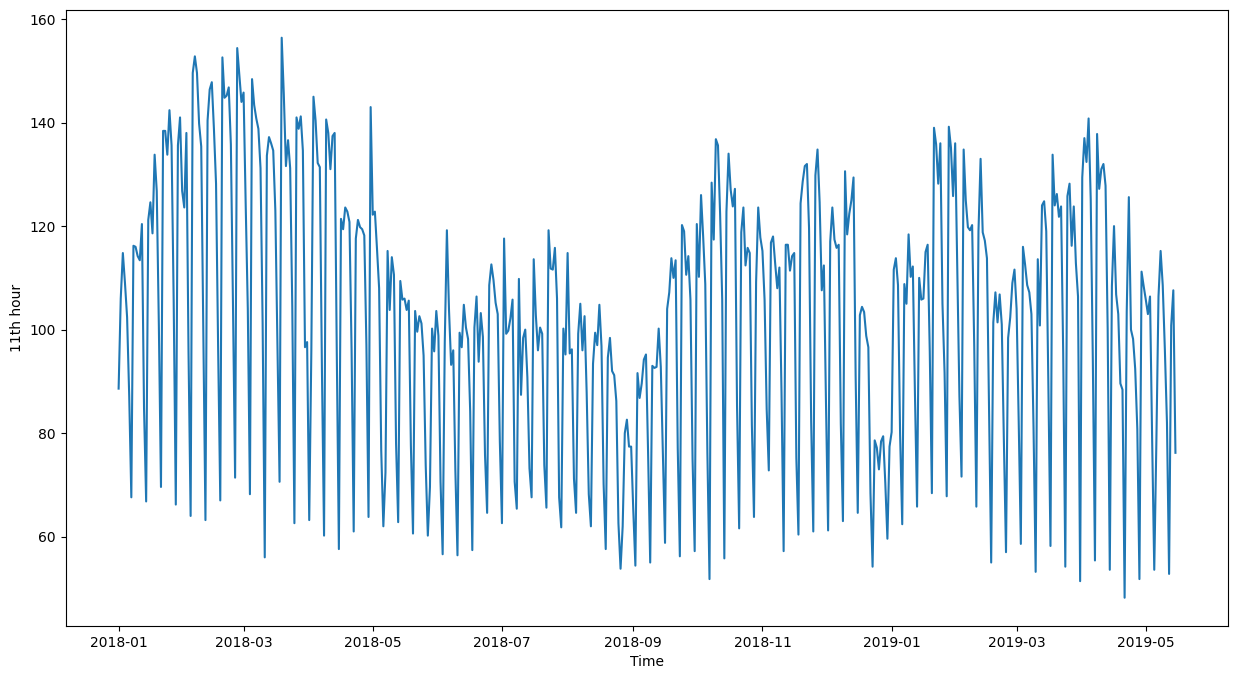

In [294]:
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(df['Dates '], df[target_name] )
plt.xlabel("Time")
plt.ylabel("11th hour")
plt.show()

In [295]:
df

,Dates,09:00,10:00,11:00
0,2018-01-01,89.4,90.6,88.6
1,2018-01-02,108.2,104.6,106.0
2,2018-01-03,110.0,111.6,114.8
3,2018-01-04,106.4,104.4,109.0
4,2018-01-05,97.8,100.4,102.4
...,...,...,...,...
495,2019-05-11,82.6,81.2,82.0
496,2019-05-12,54.8,53.0,52.8
497,2019-05-13,96.8,96.4,100.8
498,2019-05-14,105.4,105.6,107.6


In [28]:
# Data Scaling with Standard Scaler
df = df.iloc[:,3:]
scaler = StandardScaler()
df.values[:]  = scaler.fit_transform(df)


In [297]:
# Auto regrresive vectors
Train = df.iloc[:470,:]
Test = df.iloc[470:,:]

print(f'Train Size : {Train.shape}')
print(f'Test Size : {Test.shape}')

Train Size : (470, 1)
Test Size : (30, 1)


In [298]:
def autoregressor(df, shift):
    data = df.copy()
    for lag in range(1, shift):
        
        data[f't-{lag}'] = data[target_name].shift(lag)
    data.dropna(inplace =True)
    data.reset_index(drop =True, inplace = True)
    return data

train = autoregressor(Train, 11)
test = autoregressor(Test, 11)

In [299]:
X_train = train.drop(columns = [target_name])
y_train = train[target_name]
X_test = test.drop(columns = [target_name])
y_test = test[target_name]



In [318]:
# MUlti layer perceptron pipeline

def model_creation(input_shape):
    model = Sequential()
    model.add(Dense(units = 256 ,  activation = 'relu', input_shape = (input_shape,)))
    model.add(Dropout(0.5))
    model.add(Dense(units=512 , activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=512 , activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=128 , activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=64 , activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=64 , activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

def fit_model(model, X_train,y_train,X_test,y_test):
    checkpoint = ModelCheckpoint(filepath='best_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)
    history = model.fit(X_train,y_train,epochs = 50 , batch_size = 32, validation_data= (X_test,y_test),callbacks = [checkpoint])
    return model

def evaluate(model,scaler,X_test ,  y_test):
    model.load_weights('best_weights.h5')
    y_pred =  model.predict(X_test)
    y_pred = scaler.inverse_transform(np.array(y_pred).reshape(1, -1))
    y_test = scaler.inverse_transform(np.array(y_test).reshape(1, -1))
    MAPE = mean_absolute_percentage_error(y_test , y_pred)
    MAE = mean_absolute_error(y_test , y_pred)
    R2 = mean_squared_error(y_test , y_pred, squared = False)
    print(f'Mean absolute percentage Error {MAPE}')
    print(f'mean absolute Error {MAE}')
    print(f'R2 Score {R2}')
    return  MAPE,MAE,R2

In [301]:
model = model_creation(10)
model.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_353 (Dense)           (None, 256)               2816      
                                                                 
 dropout_301 (Dropout)       (None, 256)               0         
                                                                 
 dense_354 (Dense)           (None, 512)               131584    
                                                                 
 dropout_302 (Dropout)       (None, 512)               0         
                                                                 
 dense_355 (Dense)           (None, 512)               262656    
                                                                 
 dropout_303 (Dropout)       (None, 512)               0         
                                                                 
 dense_356 (Dense)           (None, 128)             

In [302]:
history = fit_model(model , X_train,y_train,X_test,y_test)

Epoch 1/50
15/15 [==============================] - 4s 51ms/step - loss: 0.7103 - val_loss: 0.3063
Epoch 2/50
15/15 [==============================] - 0s 27ms/step - loss: 0.3709 - val_loss: 0.2584
Epoch 3/50
15/15 [==============================] - 0s 23ms/step - loss: 0.3043 - val_loss: 0.2373
Epoch 4/50
15/15 [==============================] - 0s 22ms/step - loss: 0.2822 - val_loss: 0.2521
Epoch 5/50
15/15 [==============================] - 0s 22ms/step - loss: 0.2666 - val_loss: 0.3015
Epoch 6/50
15/15 [==============================] - 0s 30ms/step - loss: 0.2532 - val_loss: 0.2343
Epoch 7/50
15/15 [==============================] - 0s 27ms/step - loss: 0.2647 - val_loss: 0.2531
Epoch 8/50
15/15 [==============================] - 0s 23ms/step - loss: 0.2419 - val_loss: 0.2713
Epoch 9/50
15/15 [==============================] - 0s 25ms/step - loss: 0.2234 - val_loss: 0.2552
Epoch 10/50
15/15 [==============================] - 0s 24ms/step - loss: 0.2288 - val_loss: 0.2653
Epoch 11/

In [313]:
evaluate(model,scaler,X_test,y_test)

1/1 [==============================] - 0s 33ms/step
Mean absolute percentage Error 0.09134134227721435
mean absolute Error 7.799015655517579


(0.09134134227721435, 7.799015655517579)

array([[ 92.4,  80.8,  51.8, 111.2, 108.4, 105.8, 103. , 106.4,  78.8,
         53.6,  78.4, 106.4, 115.2, 108.6,  96.2,  82. ,  52.8, 100.8,
        107.6,  76.2]])

In [279]:
# train for different Autoregressive vectors and evaluate

results = {}
for i in range(2,10):
    x_train = train.iloc[:,1:i]
    x_test = test.iloc[:,1:i]
    model = model_creation(i-1)
    checkpoint = ModelCheckpoint(filepath='best_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)
    history = model.fit(x_train,y_train,epochs = 50 , batch_size = 32, validation_data= (x_test,y_test),callbacks = [checkpoint])
    matrix = evaluate(model,x_test,y_test)
    name = f'first {i-1} features'
    results[name] = matrix
    
    
    
    
    



Epoch 1/50
15/15 [==============================] - 4s 38ms/step - loss: 0.8717 - val_loss: 0.7919
Epoch 2/50
15/15 [==============================] - 0s 26ms/step - loss: 0.7745 - val_loss: 0.6884
Epoch 3/50
15/15 [==============================] - 0s 19ms/step - loss: 0.7375 - val_loss: 0.6912
Epoch 4/50
15/15 [==============================] - 0s 24ms/step - loss: 0.7428 - val_loss: 0.5633
Epoch 5/50
15/15 [==============================] - 0s 20ms/step - loss: 0.6998 - val_loss: 0.6052
Epoch 6/50
15/15 [==============================] - 0s 23ms/step - loss: 0.6953 - val_loss: 0.6031
Epoch 7/50
15/15 [==============================] - 1s 39ms/step - loss: 0.6826 - val_loss: 0.5134
Epoch 8/50
15/15 [==============================] - 0s 27ms/step - loss: 0.6339 - val_loss: 0.6215
Epoch 9/50
15/15 [==============================] - 0s 28ms/step - loss: 0.6237 - val_loss: 0.4726
Epoch 10/50
15/15 [==============================] - 0s 22ms/step - loss: 0.6715 - val_loss: 0.5457
Epoch 11/

15/15 [==============================] - 0s 21ms/step - loss: 0.3636 - val_loss: 0.5895
Epoch 10/50
15/15 [==============================] - 0s 26ms/step - loss: 0.3392 - val_loss: 0.6029
Epoch 11/50
15/15 [==============================] - 1s 35ms/step - loss: 0.3634 - val_loss: 0.6150
Epoch 12/50
15/15 [==============================] - 1s 36ms/step - loss: 0.3373 - val_loss: 0.5205
Epoch 13/50
15/15 [==============================] - 0s 24ms/step - loss: 0.3215 - val_loss: 0.5991
Epoch 14/50
15/15 [==============================] - 0s 18ms/step - loss: 0.3601 - val_loss: 0.5566
Epoch 15/50
15/15 [==============================] - 0s 18ms/step - loss: 0.3395 - val_loss: 0.5330
Epoch 16/50
15/15 [==============================] - 0s 22ms/step - loss: 0.2965 - val_loss: 0.5526
Epoch 17/50
15/15 [==============================] - 0s 26ms/step - loss: 0.3312 - val_loss: 0.4045
Epoch 18/50
15/15 [==============================] - 0s 27ms/step - loss: 0.3017 - val_loss: 0.4744
Epoch 19/50


15/15 [==============================] - 0s 26ms/step - loss: 0.1919 - val_loss: 0.2405
Epoch 18/50
15/15 [==============================] - 0s 25ms/step - loss: 0.2062 - val_loss: 0.2147
Epoch 19/50
15/15 [==============================] - 0s 28ms/step - loss: 0.1840 - val_loss: 0.2775
Epoch 20/50
15/15 [==============================] - 0s 23ms/step - loss: 0.2186 - val_loss: 0.2542
Epoch 21/50
15/15 [==============================] - 0s 22ms/step - loss: 0.2294 - val_loss: 0.2244
Epoch 22/50
15/15 [==============================] - 0s 23ms/step - loss: 0.1910 - val_loss: 0.2200
Epoch 23/50
15/15 [==============================] - 0s 32ms/step - loss: 0.1687 - val_loss: 0.2199
Epoch 24/50
15/15 [==============================] - 0s 26ms/step - loss: 0.1891 - val_loss: 0.2101
Epoch 25/50
15/15 [==============================] - 0s 27ms/step - loss: 0.1882 - val_loss: 0.2214
Epoch 26/50
15/15 [==============================] - 0s 25ms/step - loss: 0.1822 - val_loss: 0.1974
Epoch 27/50


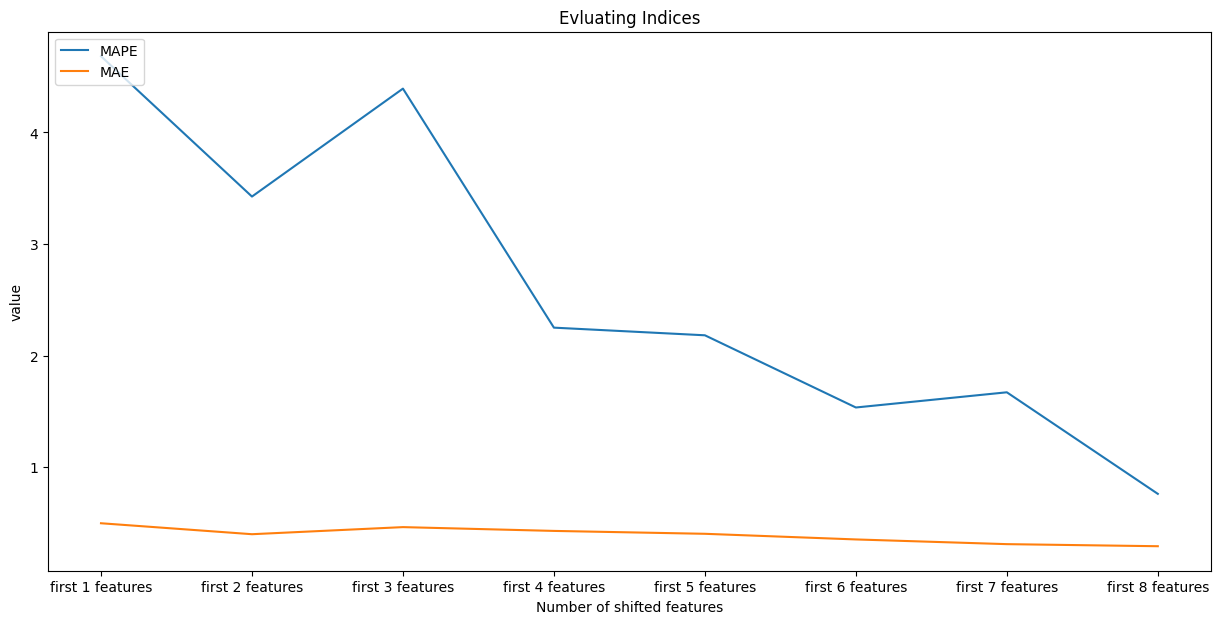

Text(0.5, 0, 'Number of shifted features')

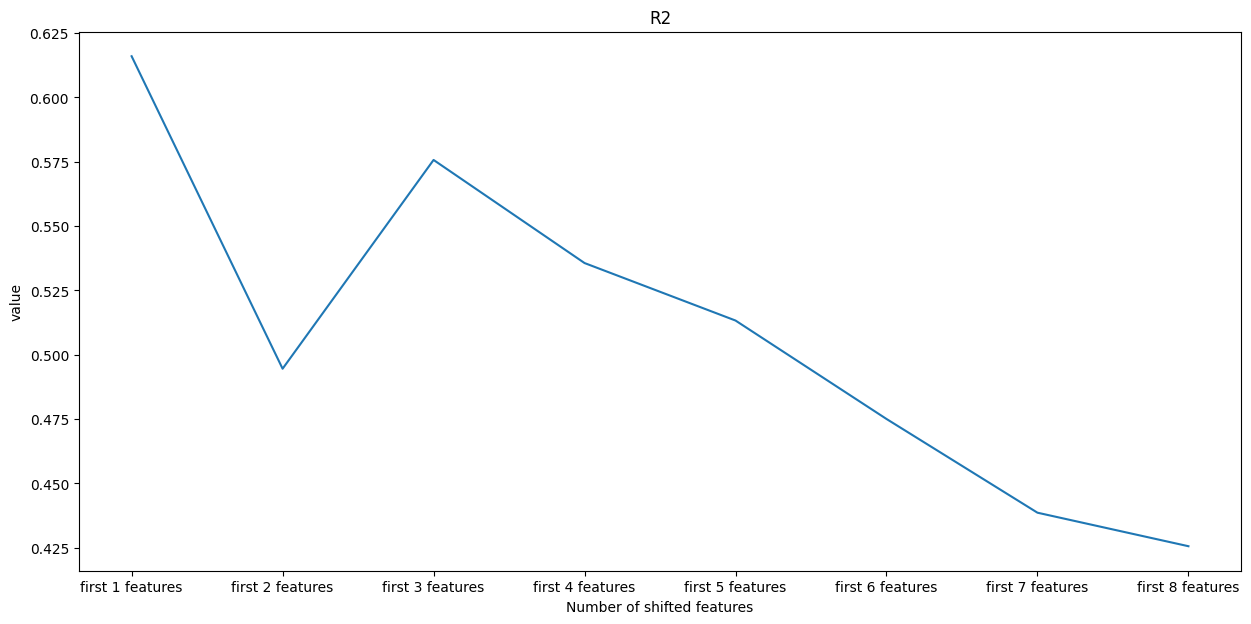

In [320]:
fig, ax = plt.subplots(figsize = (15,7))
#ax1.plot(results.keys(), [x[0] for x in results.values()])

ax.plot(results.keys(), [x[0] for x in results.values()])
ax.plot(results.keys(), [x[1] for x in results.values()])
#ax.plot(results.keys(), [x[2] for x in results.values()])
plt.title('Evluating Indices')
plt.ylabel('value')
plt.xlabel('Number of shifted features')
plt.legend(['MAPE', 'MAE'], loc='upper left')
plt.show()

fig, ax2 = plt.subplots(figsize = (15,7))
ax2.plot(results.keys(), [x[2] for x in results.values()])
plt.title('R2')
plt.ylabel('value')
plt.xlabel('Number of shifted features')


### The best model is given for first 7 features ###

In [281]:
#NARX model
df_


,Dates,09:00,10:00,11:00
0,2018-01-01,89.4,90.6,88.6
1,2018-01-02,108.2,104.6,106.0
2,2018-01-03,110.0,111.6,114.8
3,2018-01-04,106.4,104.4,109.0
4,2018-01-05,97.8,100.4,102.4
...,...,...,...,...
495,2019-05-11,82.6,81.2,82.0
496,2019-05-12,54.8,53.0,52.8
497,2019-05-13,96.8,96.4,100.8
498,2019-05-14,105.4,105.6,107.6


In [334]:

 
train_data = df_.iloc[:470,1:]
test_data = df_.iloc[470:,1:]
 
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)


X_train = train_data_scaled[:, :2]  
y_train = train_data_scaled[:, 2]  
X_test = test_data_scaled[:, :2]   
y_test = test_data_scaled[:, 2]   
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))



In [339]:
from tensorflow.keras.layers import LSTM, Dense, Concatenate, Input
from tensorflow.keras.models import Model
import tensorflow as tf

# Define the NARX model
input_layer = Input(shape=(1, 2))
lstm_layer = LSTM(50, activation='relu')(input_layer)
dense_layer_1 = Dense(1)(lstm_layer)
reshaped_layer = tf.expand_dims(dense_layer_1, axis=-1)
concat_layer = Concatenate(axis=-1)([input_layer, reshaped_layer])
dense_layer_2 = Dense(1)(concat_layer)

model = Model(inputs=input_layer, outputs=dense_layer_2)
model.compile(optimizer='adam', loss='mse')


model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1,validation_data=(X_test,y_test))



Epoch 1/100
47/47 [==============================] - 3s 4ms/step - loss: 1.1074
Epoch 2/100
47/47 [==============================] - 0s 4ms/step - loss: 1.0067
Epoch 3/100
47/47 [==============================] - 0s 4ms/step - loss: 1.0034
Epoch 4/100
47/47 [==============================] - 0s 4ms/step - loss: 0.9951
Epoch 5/100
47/47 [==============================] - 0s 4ms/step - loss: 0.9947
Epoch 6/100
47/47 [==============================] - 0s 5ms/step - loss: 0.9951
Epoch 7/100
47/47 [==============================] - 0s 5ms/step - loss: 0.9904
Epoch 8/100
47/47 [==============================] - 0s 6ms/step - loss: 0.9957
Epoch 9/100
47/47 [==============================] - 0s 4ms/step - loss: 0.9856
Epoch 10/100
47/47 [==============================] - 0s 4ms/step - loss: 0.9925
Epoch 11/100
47/47 [==============================] - 0s 4ms/step - loss: 1.0007
Epoch 12/100
47/47 [==============================] - 0s 4ms/step - loss: 0.9933
Epoch 13/100
47/47 [=================

0.7672975659370422

In [371]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 44ms/step - loss: 0.7673


0.7672975659370422